In [7]:
import csv
import requests
from bs4 import BeautifulSoup, Comment
import time
import random
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt

In [8]:

nfl_teams = {
    "Buffalo Bills" : "buf",
    "Miami Dolphins" : "mia",
    "New York Jets" : "nyj",
    "New England Patriots" : "nwe",
    "Baltimore Ravens" : "rav",
    "Cincinnati Bengals" : "cin",
    "Cleveland Browns" : "cle",
    "Pittsburgh Steelers" : "pit",
    "Houston Texans" : "htx",
    "Indianapolis Colts" : "clt",
    "Jacksonville Jaguars" : "jax",
    "Tennessee Titans" : "oti",
    "Denver Broncos" : "den",
    "Kansas City Chiefs" : "kan",
    "Los Angeles Chargers" : "sdg",
    "Las Vegas Raiders" : "rai",
    "Dallas Cowboys" : "dal",
    "New York Giants" : "nyg",
    "Philadelphia Eagles" : "phi",
    "Washington Commanders" : "was",
    "Chicago Bears" : "chi",
    "Detroit Lions" : "det",
    "Green Bay Packers" : "gnb",
    "Minnesota Vikings" : "min",
    "Atlanta Falcons" : "atl",
    "Carolina Panthers" : "car",
    "New Orleans Saints" : "nor",
    "Tampa Bay Buccaneers" : "tam",
    "Arizona Cardinals" : "crd",
    "Los Angeles Rams" : "ram",
    "San Francisco 49ers" : "sfo",
    "Seattle Seahawks" : "sea"
    
}

previous_years = ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023", "2024"]
all_teams_rosters = {}




In [9]:
for year in previous_years:

    all_teams_rosters[year] = {}

    for team_name, team_id in nfl_teams.items():
        print(f"Fetching Roster data for {team_name}")
        session = requests.Session()
        session.headers.update({
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36"
        })

        url = (f"https://www.pro-football-reference.com/teams/{team_id}/{year}_roster.htm") 
        url_request = session.get(url)
        time.sleep(random.uniform(1, 3))

        soup = BeautifulSoup(url_request.text, "html.parser")
        comments = soup.find_all(string=lambda text: isinstance(text, Comment))

        roster_table = None
    
        for comment in comments:
            if "table" in comment:
                comment_soup = BeautifulSoup(comment, "html.parser")
                roster_table = comment_soup.find("table", {"id" : "roster"})
                if roster_table:
                    break


        team_roster = []

        if roster_table:
            
            rows = roster_table.find("tbody").find_all("tr")

            for row in rows:
                columns = row.find_all('td')
                if columns:
                    player_data = {}
                    if columns[0].find('a'):
                        name = columns[0].find('a').text.strip()
                    else:
                        name = columns[0].text.strip()
                    

                    if len(columns) > 10:
                        player_value = columns[10].text.strip()
                    else:
                        player_value = "N/A"

                    player_data[name] = player_value
                    team_roster.append(player_data)

            
        

        all_teams_rosters[year][team_name] = team_roster



Fetching Roster data for Buffalo Bills
Fetching Roster data for Miami Dolphins
Fetching Roster data for New York Jets
Fetching Roster data for New England Patriots
Fetching Roster data for Baltimore Ravens
Fetching Roster data for Cincinnati Bengals
Fetching Roster data for Cleveland Browns
Fetching Roster data for Pittsburgh Steelers
Fetching Roster data for Houston Texans
Fetching Roster data for Indianapolis Colts
Fetching Roster data for Jacksonville Jaguars
Fetching Roster data for Tennessee Titans
Fetching Roster data for Denver Broncos
Fetching Roster data for Kansas City Chiefs
Fetching Roster data for Los Angeles Chargers
Fetching Roster data for Las Vegas Raiders
Fetching Roster data for Dallas Cowboys
Fetching Roster data for New York Giants
Fetching Roster data for Philadelphia Eagles
Fetching Roster data for Washington Commanders
Fetching Roster data for Chicago Bears
Fetching Roster data for Detroit Lions
Fetching Roster data for Green Bay Packers
Fetching Roster data for

In [10]:
config = {
  'user': 'wsa',
  'host': '34.68.250.121',
  'database': 'Tutorials-Winter2025',
  'password': 'LeBron>MJ!'
}

try:
    cnx = mysql.connector.connect(**config)
    print("Successfully connected to database")
except mysql.connector.Error as err:
    print(err)


cursor = cnx.cursor(buffered = True)

Successfully connected to database


In [11]:
print("Starting the data insertion process")

create_table_query = """
CREATE TABLE IF NOT EXISTS nfl_team_success (
    id INT AUTO_INCREMENT PRIMARY KEY,
    year VARCHAR(4),
    team_name VARCHAR(50),
    player_name VARCHAR(100),
    player_value VARCHAR(50)
)
"""

try:
    cursor.execute(create_table_query)
    cnx.commit()
    print("Table created or already exists.")
except mysql.connector.Error as err:
    print(f"Error when creating table: {err}")

insert_query = """
INSERT INTO nfl_team_success (year, team_name, player_name, player_value)
VALUES (%s, %s, %s, %s)
"""

inserted_rows = 0

for year, teams in all_teams_rosters.items():
    for team, roster in teams.items():
        for player in roster:
            for name, value in player.items():
                try:
                    cursor.execute(insert_query, (year, team, name, value))
                    inserted_rows += 1

                    if inserted_rows %100 == 0:
                        cnx.commit()
                        print(f"Inserted {inserted_rows} rows so far")
                except mysql.connector.Error as err:
                    print(f"Error inserting data: {err}")


print("Inserted complete")



Starting the data insertion process
Table created or already exists.
Inserted complete


In [ ]:
queryPlayerData = "SELECT * FROM `Tutorials-Winter2025`.nfl_team_success;"
df_playerData = pd.read_sql(queryPlayerData, cnx)

queryTeamData = "SELECT * FROM `Tutorials-Winter2025`.NFL_Team_Records_10_to_24;"
df_teamData = pd.read_sql(queryTeamData, cnx)

team_year_players = df_playerData.groupby(['year', 'team_name'])['player_name'].apply(set).reset_index()

    


years = team_year_players['year'].unique()
teams = team_year_players['team_name'].unique()


def get_players_for_year_team(df, target_year, target_team):
    find_year_team = (df['year'] == target_year) & (df['team_name'] == target_team)
    player_set = df.loc[find_year_team, 'player_name']

    return player_set.values
   
retention = {}

for index, year in enumerate(years):
    teams_rr_yearly = {}
    for team in teams:
        retention_rate = 0
        if (index != 0):
            prev_year = str(int(year) - 1)

            prev_year_player_info = get_players_for_year_team(team_year_players, prev_year, team)
            curr_year_player_info = get_players_for_year_team(team_year_players, year, team)

            intersection = curr_year_player_info & prev_year_player_info
            
            retention_rate = round(len(intersection[0]) / len(curr_year_player_info[0]), 5)

        teams_rr_yearly[team] = retention_rate

    retention[year] = teams_rr_yearly


        
    


/var/folders/z9/mc8t_cn5695fq2783myrpych0000gn/T/ipykernel_34253/254940029.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_playerData = pd.read_sql(queryPlayerData, cnx)
/var/folders/z9/mc8t_cn5695fq2783myrpych0000gn/T/ipykernel_34253/254940029.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_teamData = pd.read_sql(queryTeamData, cnx)


{'2010': {'Arizona Cardinals': 0, 'Atlanta Falcons': 0, 'Baltimore Ravens': 0, 'Buffalo Bills': 0, 'Carolina Panthers': 0, 'Chicago Bears': 0, 'Cincinnati Bengals': 0, 'Cleveland Browns': 0, 'Dallas Cowboys': 0, 'Denver Broncos': 0, 'Detroit Lions': 0, 'Green Bay Packers': 0, 'Houston Texans': 0, 'Indianapolis Colts': 0, 'Jacksonville Jaguars': 0, 'Kansas City Chiefs': 0, 'Las Vegas Raiders': 0, 'Los Angeles Chargers': 0, 'Los Angeles Rams': 0, 'Miami Dolphins': 0, 'Minnesota Vikings': 0, 'New England Patriots': 0, 'New Orleans Saints': 0, 'New York Giants': 0, 'New York Jets': 0, 'Philadelphia Eagles': 0, 'Pittsburgh Steelers': 0, 'San Francisco 49ers': 0, 'Seattle Seahawks': 0, 'Tampa Bay Buccaneers': 0, 'Tennessee Titans': 0, 'Washington Commanders': 0}, '2011': {'Arizona Cardinals': 0.62069, 'Atlanta Falcons': 0.68421, 'Baltimore Ravens': 0.56667, 'Buffalo Bills': 0.55385, 'Carolina Panthers': 0.40299, 'Chicago Bears': 0.53226, 'Cincinnati Bengals': 0.68421, 'Cleveland Browns': 0.4

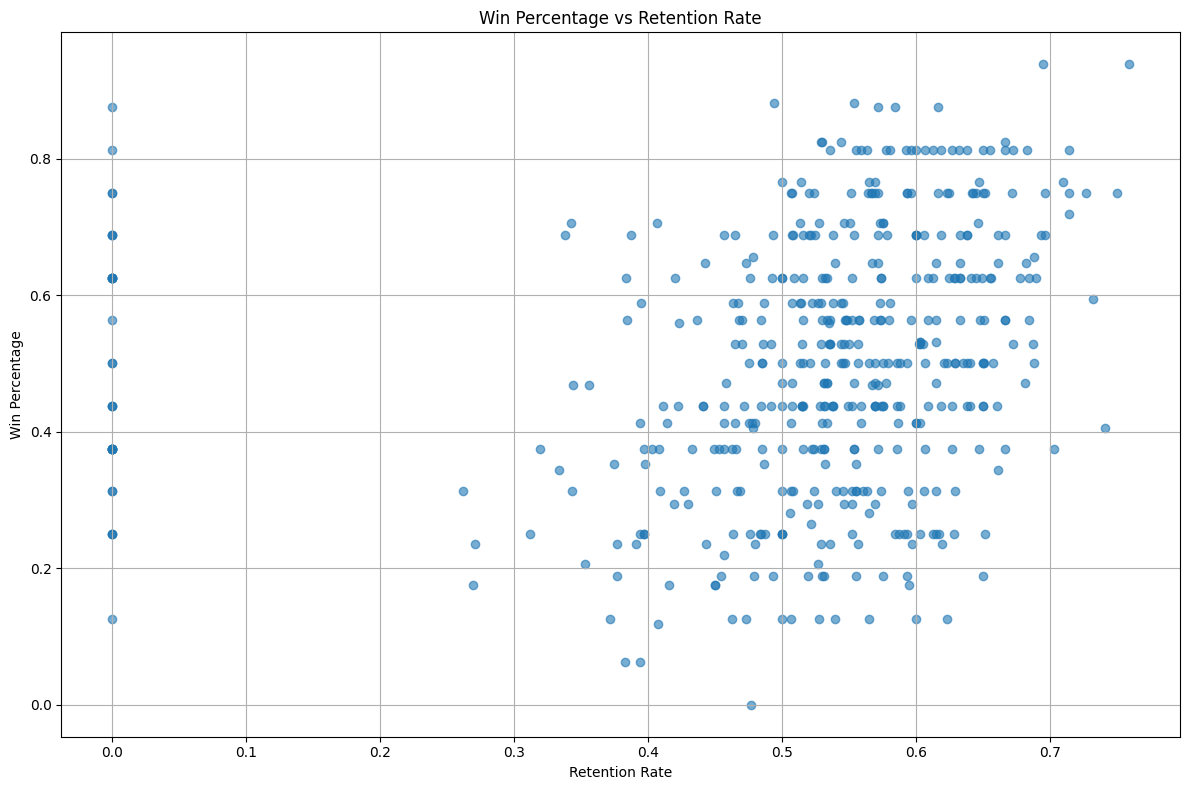

In [148]:

win_percentages = []
retention_rates = []
teams = []
years = []

for year, team_info in retention.items():
    for name, rr in team_info.items():
        
        win_percentage_series = df_teamData.loc[(df_teamData["team"] == name) & (df_teamData["year"] == int(year)), "win_percentage"]
        win_percentage = win_percentage_series.values[0]
        
        win_percentages.append(win_percentage)
        retention_rates.append(rr)
        teams.append(name)
        years.append(int(year))

    
plot_data = pd.DataFrame({
'team': teams,
'year': years,
'win_percentage': win_percentages,
'retention_rate': retention_rates
})
plt.figure(figsize=(12, 8))
plt.scatter(plot_data['retention_rate'], plot_data['win_percentage'], alpha=0.6)



plt.xlabel('Retention Rate')
plt.ylabel('Win Percentage')
plt.title('Win Percentage vs Retention Rate')
plt.grid(True)
plt.tight_layout()
plt.show()
    
